# Inspiration : [Image duplicates using imagehash](https://www.kaggle.com/nickuzmenkov/pp2021-duplicates-revealing)

# Setup

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import tensorflow as tf
import joblib
import imagehash

from tqdm import tqdm

# Read the csv data

In [2]:
df = pd.read_csv("../input/plant-pathology-2021-fgvc8/train.csv",
                 index_col = "image")
df.head()

labels
image                                                
800113bb65efe69e.jpg                          healthy
8002cb321f8bfcdf.jpg  scab frog_eye_leaf_spot complex
80070f7fb5e2ccaa.jpg                             scab
80077517781fb94f.jpg                             scab
800cbf0ff87721f8.jpg                          complex

#  Resize the images - downscale them to 512 x 512

In [3]:
IMG_DIR = "../input/plant-pathology-2021-fgvc8/train_images"
PATHS = os.listdir(IMG_DIR)
IMG_SIZE = 512


In [4]:
def resize_image(path, size = IMG_SIZE):
    full_path = os.path.join(IMG_DIR, path)
    img = tf.io.read_file(full_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE], method = 'nearest')
    img = tf.cast(img, tf.uint8).numpy()
    plt.imsave(path, img)

%time  r = joblib.Parallel(n_jobs = -1)(joblib.delayed(resize_image)(path) for path in PATHS)

CPU times: user 5min 1s, sys: 1min 7s, total: 6min 8s
Wall time: 10min 5s


# Compute hashes on the images

In [5]:
image_ids = []

for path in tqdm( tf.io.gfile.glob('./*.jpg'), total = len(tf.io.gfile.glob('./*.jpg'))):
    image_ids.append(path.split('/')[-1])
image_ids = np.array(image_ids)


100%|██████████| 18632/18632 [00:00<00:00, 958733.34it/s]


In [6]:
def hash_image(image_path):
    img = Image.open(image_path)
    avg_hash = imagehash.average_hash(img).hash
    p_hash = imagehash.phash(img).hash
    d_hash = imagehash.dhash(img).hash
    w_hash = imagehash.whash(img).hash
    return np.concatenate([avg_hash, p_hash, d_hash, w_hash]).reshape(-1,)

%time  hashes = joblib.Parallel(n_jobs = -1)(joblib.delayed(hash_image)(path) for path in tf.io.gfile.glob('./*.jpg'))

CPU times: user 44.2 s, sys: 1.6 s, total: 45.8 s
Wall time: 4min 12s


# Similarity

In [7]:
%time similarity = [ np.array(hashes[i] == hashes).sum(axis = 1) / 256. for i in range(len(hashes)) ]


CPU times: user 7min 30s, sys: 13.7 s, total: 7min 44s
Wall time: 7min 44s


In [8]:
# symmetric matrix, if image a is duplicate of image b <=> image b is a duplicate of image a
# we need just one pair
similarity = np.triu(similarity)

In [9]:
# 90% matching

THRESHOLD = 0.9
mask = np.where(np.array(similarity) > THRESHOLD)

In [10]:
# get rid of similarity[i][j] where i == j
indices = np.where(mask[0] != mask[1])


In [11]:
image_set1 = [image_ids[i] for i in mask[0][indices]]
image_set2 = [image_ids[i] for i in mask[1][indices]]

In [12]:
dups = [(i1, i2) for i1, i2 in zip(image_set1, image_set2)]
print('Found %d duplicates' % len(dups))

Found 50 duplicates


In [13]:
duplicates = pd.DataFrame( columns = ["image1", "image2", "label1", "label2", "label"])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


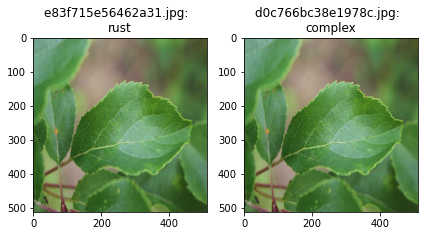

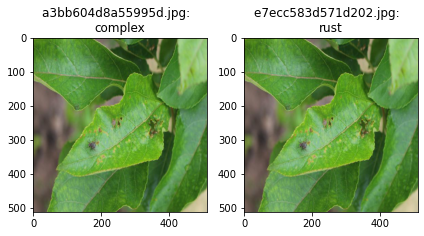

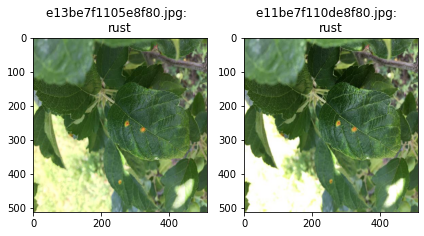

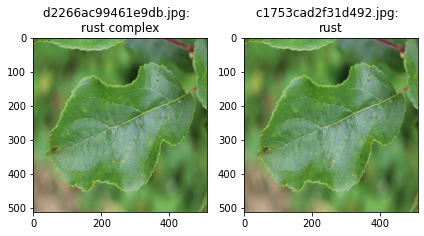

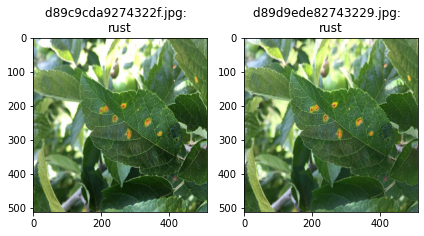

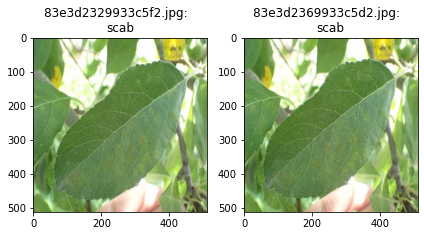

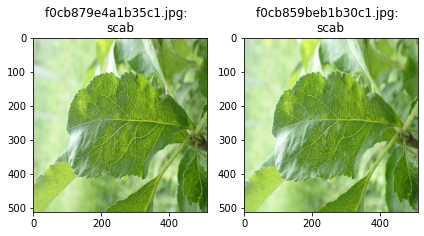

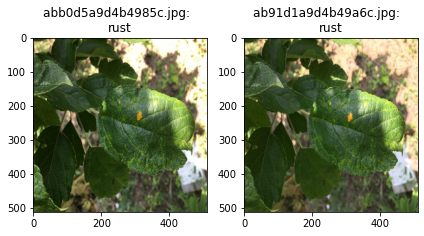

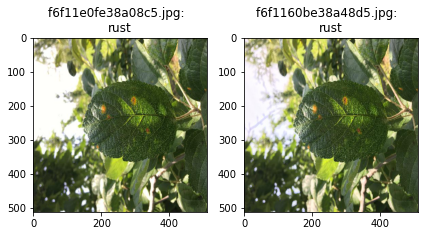

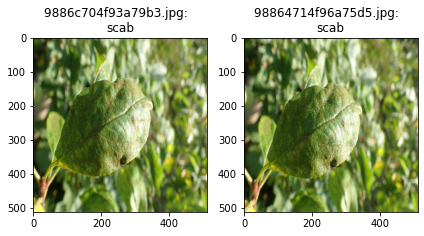

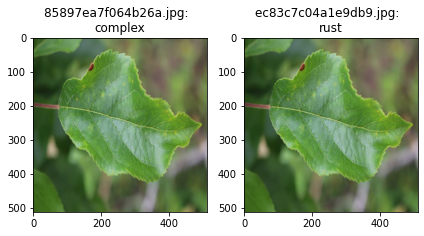

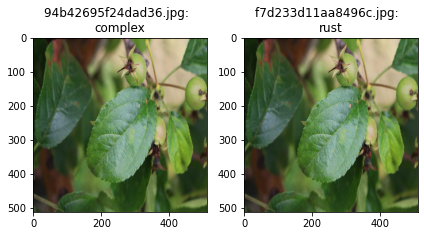

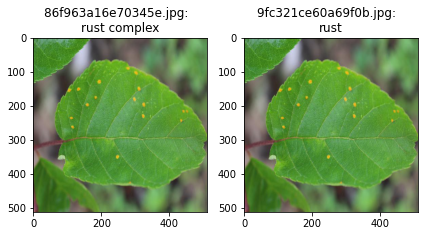

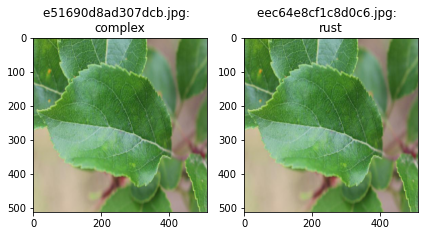

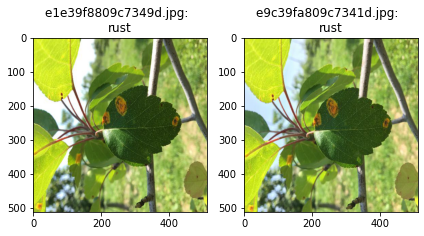

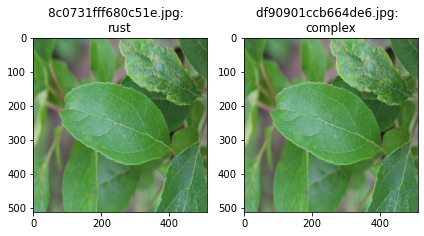

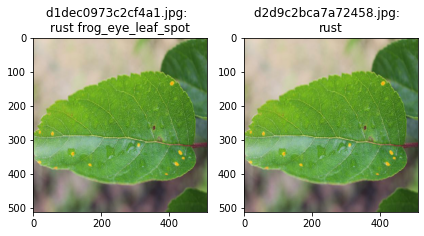

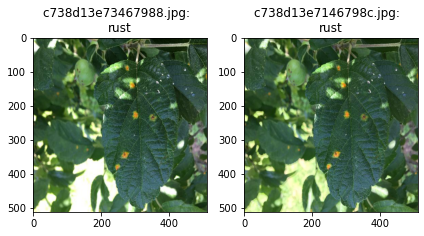

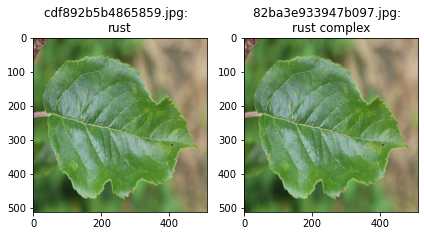

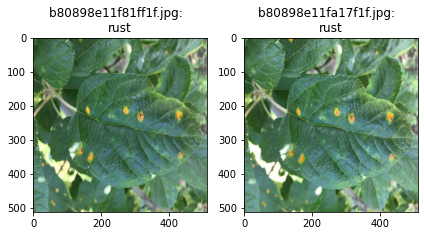

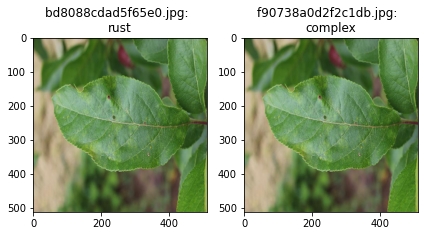

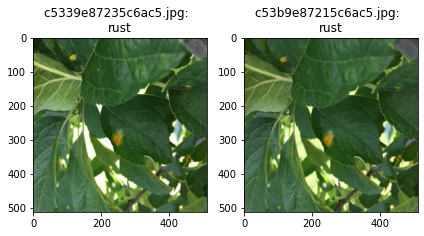

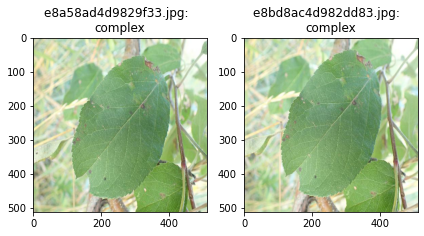

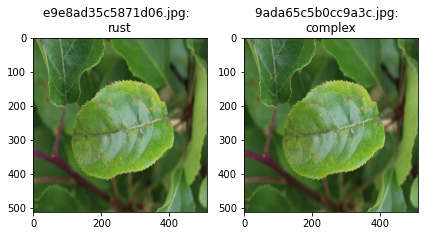

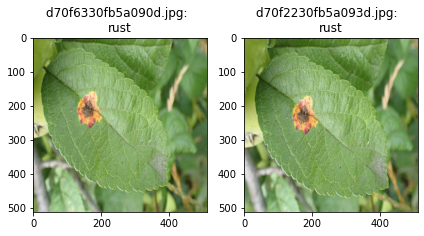

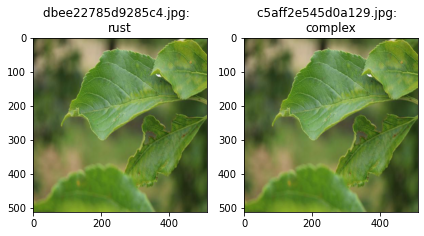

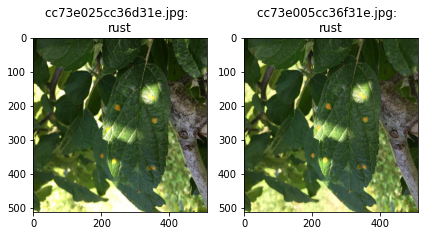

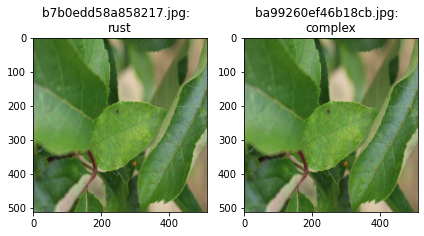

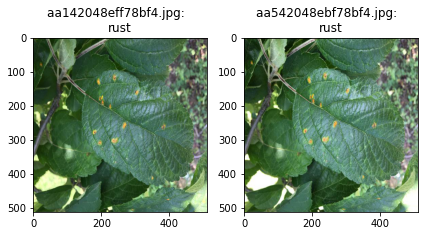

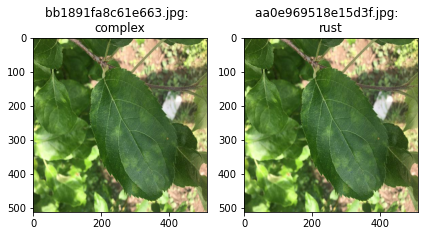

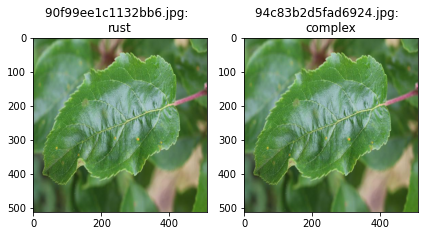

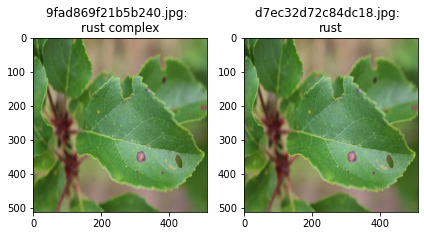

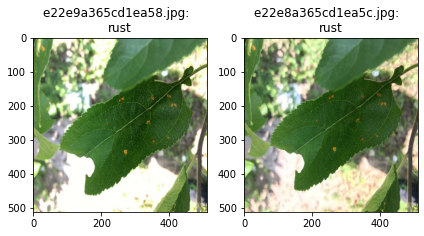

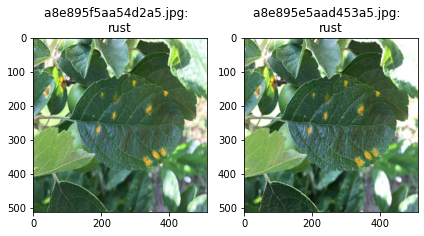

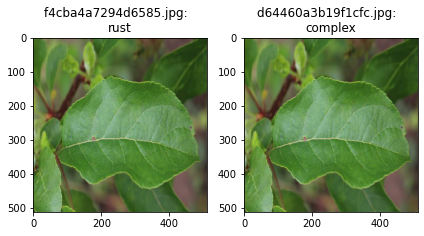

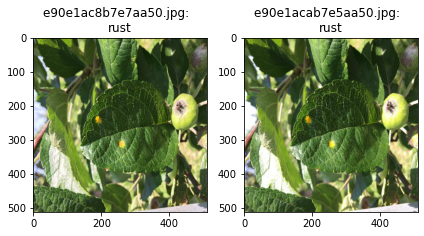

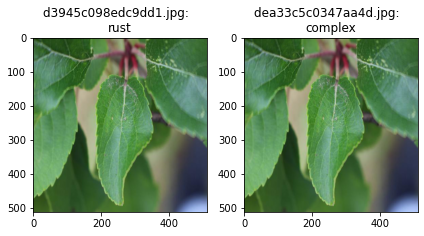

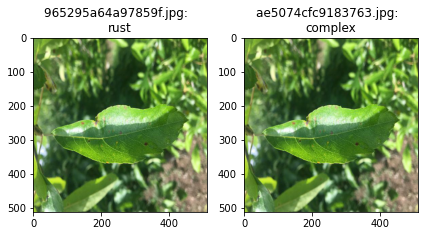

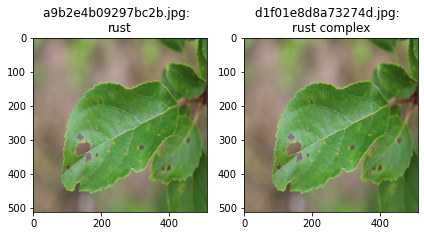

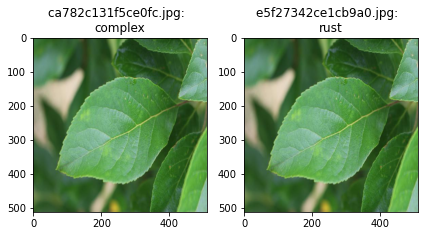

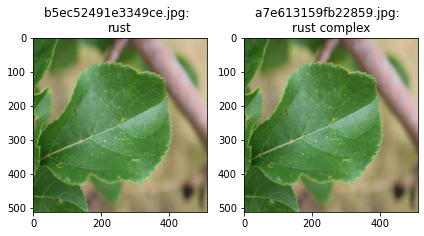

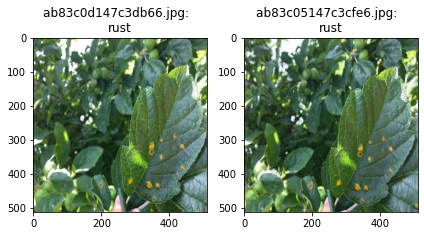

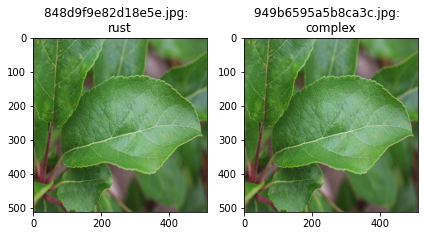

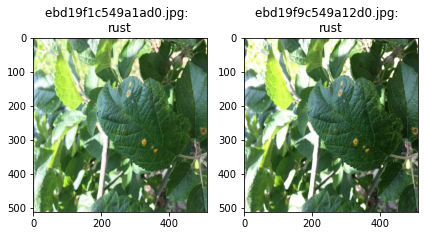

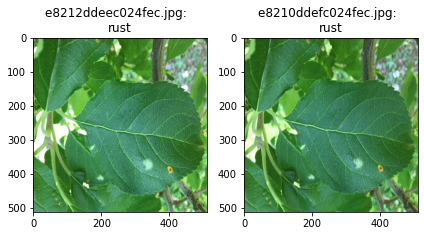

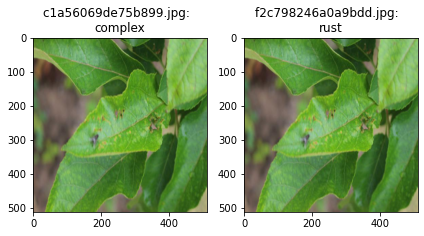

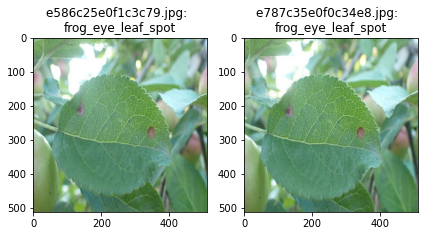

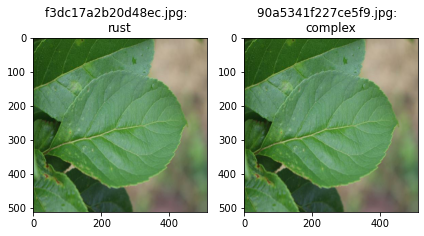

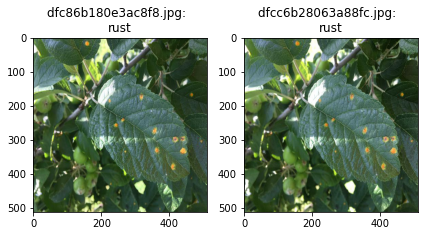

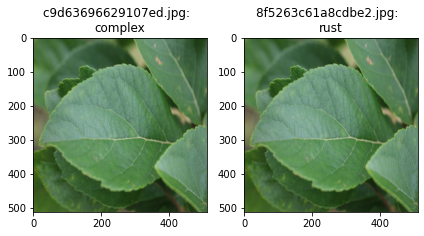

In [14]:
for i1, i2 in zip(image_set1, image_set2):

    image1 = Image.open(i1)
    image2 = Image.open(i2)
    
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(image1)
    label1 = df.loc[i1, 'labels']
    axes[0].set_title(i1 + ":  \n" + label1)
    axes[1].imshow(image2)
    label2 = df.loc[i2, 'labels' ]
    axes[1].set_title(i2 + ":  \n" + label2)
    fig.tight_layout()
    
    label = None
    if label1 == label2:
        label = label1
    elif label1 in label2:
        label = label2
    elif label2 in label1:
        label = label1
    elif label1 == "complex" or label2 == "complex":
        label = "complex"
    new_row = {'image1': i1, 'image2': i2, 'label1': label1, 'label2': label2, 'label' : label}
    duplicates = duplicates.append(new_row, ignore_index=True)


In [15]:
duplicates.to_csv("duplicates.csv", index = False)

In [16]:
for file in tf.io.gfile.glob('./*.jpg'):
    os.remove(file)